<a href="https://colab.research.google.com/github/van-dang/FEniCS-Colab/blob/master/TestODECoupling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

gmsh_dir=!which gmsh
if len(gmsh_dir)==0:
  !apt-get install gmsh
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

clear_output()

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

# Disable warnings
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger("rothemain.rothe_utils")
logging.getLogger('UFL').setLevel(logging.WARNING)
logging.getLogger('FFC').setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")


dolfin version: 2019.1.0


t= 10.0
0.007936247533620207 921.7994386405999 0.005200297916732099


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


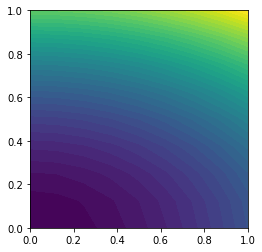

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


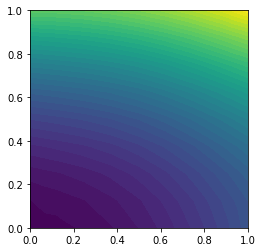

In [165]:
from fenics import *
import numpy as np


def compute_est(theta, u_L, u_H):
    """Return error estimate by Richardson extrapolation"""
    p = 2 if theta == 0.5 else 1
    est = sqrt(assemble((u_L - u_H)**2*dx)) / (2**p - 1)
    return est


def compute_new_dt(theta, est, tol, dt):
    """Return new time step"""
    p = 2 if theta == 0.5 else 1
    rho = 0.9
    dt_new = dt * ( rho * tol / est )**(1/p)
    return dt_new

  
T = 10.0            # final time
num_steps = 5     # number of time steps
dt = T / num_steps # time step size
alpha = 3          # parameter alpha
beta = 1.0         # parameter beta

# Create mesh and define function space
nx = ny = 8
mesh = UnitSquareMesh(nx, ny)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t*t',
                 degree=2, alpha=alpha, beta=beta, t=0)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

# Define initial value
u0 = interpolate(u_D, V)


# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)

def f(t):
  return(2*beta*t - 2 - 2*alpha)

J = assemble(dot(grad(u), grad(v))*dx)
M = assemble(u*v*dx)
b = assemble(v*dx)

theta = 0.5;

def single_step(theta, t, tp, dt, u, Jac, ff):
  u_D.t = t;
  Al=1./dt*M + theta*Jac;
  Ar=1./dt*M -(1-theta)*Jac;
  rhs = Ar*u.vector() + (theta*ff(t) + (1-theta)*ff(tp))*b;
  bc.apply(Al, rhs)
  u = Function(V)
  solve(Al, u.vector(), rhs)
  return u

u = Function(V)

tp = 0;
t = tp + dt;
tol = 1e-4;

dt_array=[];
while t<T:
  u_low  = single_step(theta, t,              tp,            dt,     u0, J, f)
  u_mid  = single_step(theta, 0.5*(t + tp),   tp,            dt/2,   u0, J, f)
  u_high = single_step(theta, t,              0.5*(t + tp),  dt/2,   u_mid, J, f)
  
  est = compute_est(theta, u_low, u_high)
  dt_new = compute_new_dt(theta, est, tol, dt)
  dt_new = min(dt_new, T-t)
  # print(est, dt_new, t)
  if est > tol:
      dt = dt_new
  else:
      tp = t;
      t += dt
      t = min(t, T)
      dt_array.append(dt)
      dt = dt_new
      u0.vector()[:] = u_high.vector()[:]

print('t=',t)      
u_D.t = t;
ue = interpolate(u_D,V)
est = compute_est(theta, ue, u0)
print(est, ue.vector().norm('l2'), np.mean(dt_array))

plot(ue)
plt.figure();
plot(u0)